## Hands-On Machine Learning with Scikit-Learn & TensorFlow

### Chapter 2: End-to-end Machine Learning Project

This chapter covers the basic machine learning project workflow:
    
    1. Look at the big picture.
    2. Get the data.
    3. Discover and visualize the data to gain insights.
    4. Prepare the data for Machine Learning algorithms.
    5. Select a model and train it.
    6. Fine-tune your model.
    7. Present your solution.
    8. Launch, monitor and maintain your system.
    

### 1. Look at the big picture

The data used for this tutorial is a collection median housing prices for blocks (the smallest geographical unit that the US Census Bureau publishes) in California. Blocks typically have populations between 600 to 3,000 people. The goal of the project is to predict the median house price for each block using attributes related to location, population, households, income and housing characteristics.

In [1]:
# Import statements
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import hashlib

### 2. Get the data

The data for this tutorial is publicly available on the GitHub site for the Hands-On Machine Learning book: https://github.com/ageron/handson-ml

Getting the data involves loading the dataset, basic data exploration to show the features in the dataset, dataset size and shape, and conducting the train/test splits.

In [2]:
# Read in data
housing = pd.read_csv("handson-ml-master/datasets/housing/housing.csv")

In [3]:
# Data snapshot
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Info on number of records, columns and column types
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Categorical variable value counts
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# Summary of numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


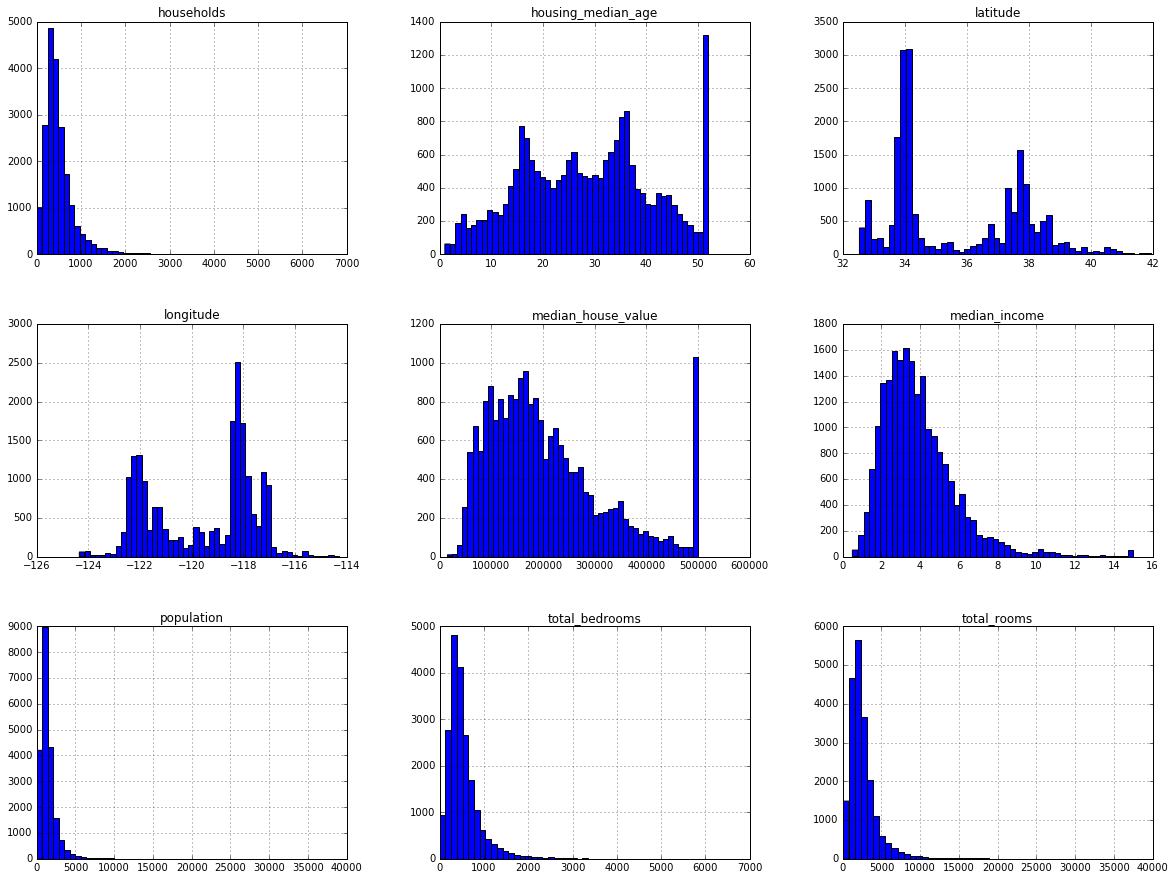

In [7]:
# Histograms of numerical attributes
housing.hist(bins=50, figsize=(20,15))
plt.show()

#### Custom train/test split functions

Splitting training and test datasets is relatively trivial, except that
you should ensure that your test set is consistent and reproducible across
multiple runs of the program. The hash method below to split on a unique
identifier is one solution to this approach.

In [8]:
# Train/test split (using hashlib to keep test set consistent)

# Naive train/test splits are generated randomly, but this approach
# lacks consistency across multiple runs of the program
def naive_split_train_test(data, test_ratio):
    """ This function splits a dataset into a training and
    test split, but does so using randomly shuffled indices. Unless
    The randomization is constant from run to run this will generate a
    different test set each time it is used. This approach is not ideal."""
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def test_set_check(identifier, test_ratio, hash):
    """This function uses each instance's unique identifier
    to determine if it should go in the test set. It computes
    a hash of each instance's identifier, keeps just the last byte,
    and puts the instance in the test set if the value is lower or equal
    to the test_ratio * 256). This ensures test set consistency across
    multiple runs of the program."""
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    """This is an improved train/test split function that keeps the test
    set consistent from run to run using the hash technique described in the
    test_set_check function. It requires a unique identifier per instance,
    which can be set by adding a row index to the data if no unique 
    identifier is already present."""
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Adding a unique identifier to the housing data
# Option one: use a row index (problematic if adding new rows to data or deleting rows in the future)
housing_with_id = housing.reset_index() # adds an 'index' column
# Option two: use stable column attributes to create a unique index
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

# Split the data
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print(len(train_set), "train +", len(test_set), "test")

16267 train + 4373 test


#### Alternatively you can use scikit-learn's train/test split function
This function uses randomly shuffled indices with a random_state parameter
to keep the test set consistent across multiple runs

In [9]:
# Scikit-learn train test split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


#### Train/test splits when stratified sampling is necessary

Sometimes you want your training and test sets to be consistent with respect to certain values in the data, such as the median income for the blocks represented. Stratified sampling in the train/test split function can achieve this goal.

In [10]:
# Create a categorical variable to represent median income strata
# First, we divide the median income (scaled between 0-16 in this data) by 1.5 to limit
# the number of categories and round up using ceil to create discrete categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Then we merge all categories greater than 5 into category 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# Next, we do stratified sampling with sklearn
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Check to make sure samples are representative of overall income distribution

print("Overall housing proportions by income: ", housing["income_cat"].value_counts() / len(housing))
print("Training data proportions by income: ", strat_train_set["income_cat"].value_counts() / len(strat_train_set))
print("Test data proportions by income: ", strat_test_set["income_cat"].value_counts() / len(strat_test_set))

Overall housing proportions by income:  3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
Training data proportions by income:  3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
Test data proportions by income:  3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [11]:
# Remove the income category variable in the training and test
# sets now that it is no longer needed
for df in (strat_train_set, strat_test_set):
    df.drop(["income_cat"], axis=1, inplace=True)

### 3. Discover and visualize the data to gain insights

This section covers exploring the dataset in more depth, including looking for trends, patterns, useful correlations and other features through data visualization and analysis.

**First:** Create a copy of the dataset for exploratory data analysis. With larger datasets this may be a sample from the original that is more manageable for data visualizations, etc.

In [12]:
# Copy the data to preserve the original
housing = strat_train_set.copy()

**Visualizations**

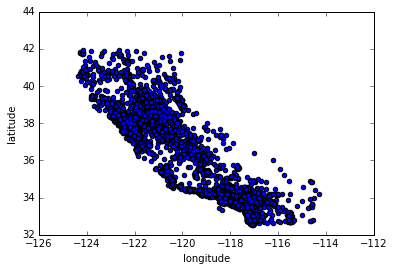

In [13]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Notice the above plot of longitude and latitude looks like California, where the housing blocks in this dataset are located.

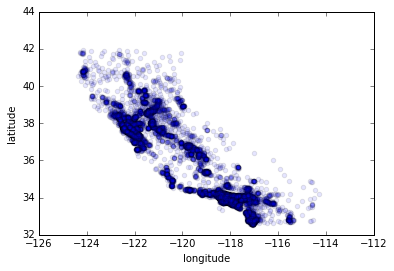

In [14]:
# Better visualization with density highlighted
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

The version above shows high density areas around the Bay Area, Los Angeles and San Diego.

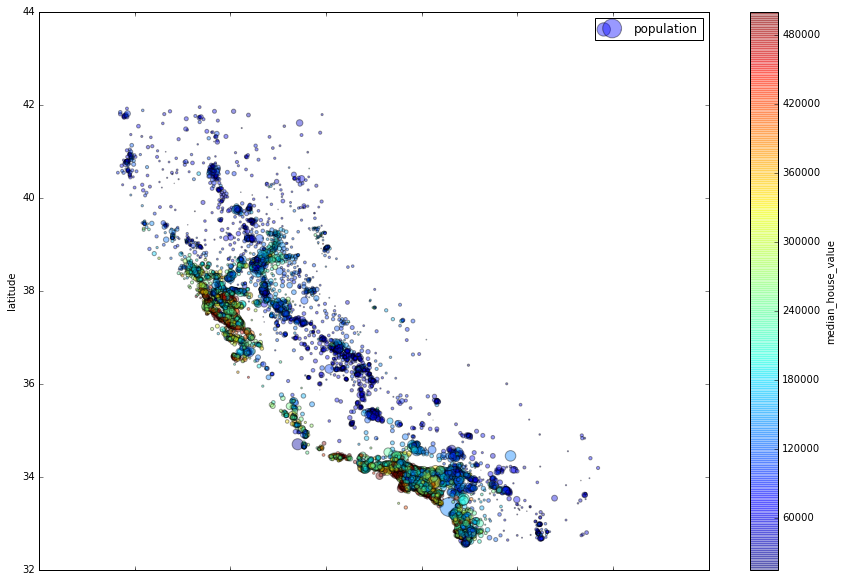

In [15]:
# Even better version with population and price data incorporated
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,10))
plt.legend()

The s option sets a size of each circle based on an additional variable (population used here), and the c option sets a color based on an additional variable (price used here) with the cmap set to a pre-defined color map ("jet") that ranges from blue to red. Much more information is incorporated in this scatter plot than the previous versions.

**Correlations**

In [16]:
# Pairwise correlations of the entire dataset (only useful for small datasets)
corr_matrix = housing.corr()

In [17]:
# Examining correlations with median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D694748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A628710>]], dtype=object)

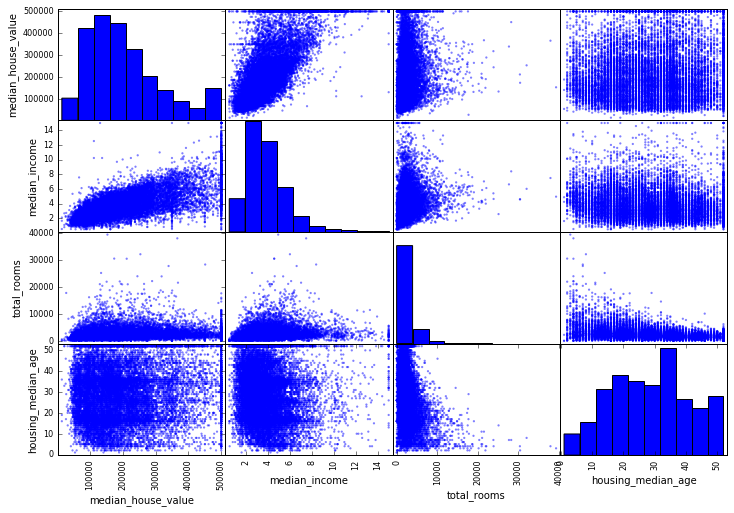

In [18]:
# Scatter matrix of correlations
from pandas.plotting import scatter_matrix

# The number of plots defaults to the number of features k-squared
# Important to limit to just a few important features instead of printing
# all possible plots
attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

The variable that has the best approximately linear relationship with our outcome variable (median_house_value) is median_income. We can zoom in on just that plot with the code below.

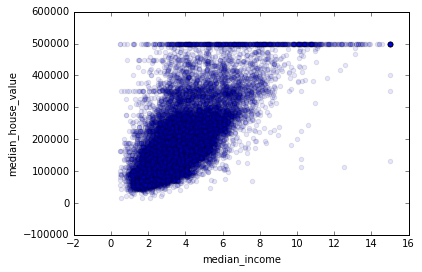

In [19]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

You can notice various things from the above plot. The correlation between these two variables is strong, with an upward right sloping relationship between median_house_value and median_income. The price cap in the data (at 500,000) is clearly evident as well, truncating any useful information that might have been gleaned from houses that have values above that artificial limit. There are some additional arbitrary data relationships found in the plot (horizontal lines around 450,000 and 280,000 that are not well explained.

**Variable interactions**

Another useful data exploration step is to try to look at interactions between different features in the data. For example, in this dataset, some features are less useful on their own than they would be in combination with another variable. The total number of rooms in a block is less useful than the number of rooms per household, for example. Some attempts to combine features are made below.

In [20]:
# Feature combinations
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [21]:
# Examine correlations with new features added
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new bedrooms_per_room feature has a stronger correlation with median_house_value than either the total_bedrooms or total_rooms features do, so this new feature is promising. The rooms_per_household feature also outperforms the original features in the dataset.

### 4. Prepare the Data for Machine Learning Algorithms

In this section, we write functions to prepare the data for machine learning. Functions allow for reproducible transformations that can be validated and reused in future projects. Additionally, they make for more production-ready implementations of your data processing pipeline.

In [22]:
# Starting with a clean copy of the training dataset
housing = strat_train_set.drop("median_house_value",axis=1) # dropping outcome variable from train
housing_labels = strat_train_set["median_house_value"].copy() # keeping outcome as separate series

**Data Cleaning** -- Dealing with Missing Values

There are three basic options for dealing with missing data:
1. Remove entire rows where some features have missing values
2. Remove entire features where some rows have missing values
3. Set the missing values to some value (zero, median, other, etc.)

Pandas has methods for all three cases, respectively, demonstrated below:
1. dropna()
2. drop()
3. fillna()

In [23]:
# Replacing missing values with Pandas, three options:
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median) # option 3

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Le

Scikit-Learn also has a method for imputing missing data (equivalent to option 3)|

In [24]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median") # only works on numeric attributes

# Create a subset of the training data with only numeric attributes
housing_num = housing.drop("ocean_proximity", axis=1)
# Train the imputer to replace all missing values with medians
imputer.fit(housing_num)

# Imputer stores the median values in statistics_ instance variable
print(imputer.statistics_)
print(housing_num.median().values) # should yield same numbers as above

# Now you can use the fitted imputer to actually replace the values
X = imputer.transform(housing_num) # results in a numpy array

# Convert numpy array back to pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

[ -118.51      34.26      29.      2119.5      433.      1164.       408.
     3.5409]
[ -118.51      34.26      29.      2119.5      433.      1164.       408.
     3.5409]


Note: an advantage of the scikit-learn approach is that it is consistently applied to all numeric columns in the data. The original training data may only contain missing values for some attributes, but if the model is put into production, there is no guarantee that other attributes will not also have missing values in the future. The bones of this approach can be rolled into pipelines that apply these types of transformations conisistently and reliably to data collected in the future.

**Handling Text and Categorical Attributes**

Text and categorical attributes can be transformed into various numeric representations for machine learning applications. One example, for transforming ocean_proximity, is below.

In [25]:
# Map each category to a numeric label
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)

# Look at the classes for each numeric label
print(encoder.classes_)

[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


The downside to the above representation is the each numeric label is still just a label. "Near Ocean" is not 4x greater than "Inland", necessarily, but the numeric labels (4 vs. 1) suggest that this is the case. We would rather encode these so that each category is either unrelated to the others or carries some actually useful numeric value.

One-hot encoding does the former. It represents each label as either a 1 or 0 so that only one of the categories is "hot" (i.e. "on" or 1) at a time. Example code is below.

In [26]:
# Map each category to one-hot encoding label
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot # output is a SciPy sparse matrix

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [27]:
# Example of what a dense version of the one-hot matrix would
# look like (lots of zeroes)
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

The above one-hot encoding process took two steps (one step to go from text to numeric label with LabelEncoder() and a second step to go from numeric label to one-hot encoding with OneHotEncoder(). This can be done with just one step by using LabelBinarizer().

In [28]:
# Map each category from text directly to one-hot encoding
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot # returns a dense NumPy array by default

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [29]:
# Return a sparse matrix instead of dense using same approach as above
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

**Custom transformers**

Scikit-learn transformations are consistent in that each has fit(), transform() and fit_transform() methods. You can create your own transformers by simply following the same format for a new class that also has these methods. This will allow for seamlessly integrated custom transformers within your scikit-learn data cleaning workflow.

In [30]:
# Implement custom transformer
from sklearn.base import BaseEstimator, TransformerMixin # used to inherit some basic classes

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

# Custom transformer to add interaction variables
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs used here
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # do nothing else
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values) # returns array of values

# Convert new attributes back to dataframe
# Generate new column names
cols = housing.columns.tolist()
cols.extend(("rooms_per_household","population_per_household"))
new_columns = np.asarray(cols)
# Save as dataframe
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=new_columns)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


**Features scaling**

Machine learning algorithms tend to perform better when the features have the same of similar scales (means and variance, etc.). Two common scaling techniques are min-max scaling and standardization. 
- **Min-max scaling** transforms all values so they are scaled between 0 and 1 (this is done by subtracting the min value and dividing by the max minus the min). This is implemented in scikit-learn with the MinMaxScaler transformer.
- **Standardization** transforms all values so they have a mean of 0 and a standard deviation of 1. This is done by subtracting the mean and dividing by the variance. Standardization is less affected by extreme outliers than normalization, but there are cases where having the inputs over the same range (0 to 1) is preferable as well. Standardization is done with scikit-learn's StandardScaler transformer.

You can also min-max scale or standardize data using scikit-learn's preprocessing methods, as demonstrated below.

In [31]:
from sklearn import preprocessing
# First, we bind float64 datatypes to float32
# This saves memory space and is necessary because the preprocessing
# methods do not work on data types of float64 size
for col, dtype in zip(housing_tr.columns, housing_tr.dtypes):
    if dtype == np.float64:
        housing_tr[col] = housing_tr[col].astype(np.float32)

# Min-max scale the data
min_max_scaler = preprocessing.MinMaxScaler()
minmaxscale_X = min_max_scaler.fit_transform(housing_tr)
# Standardize the data
standardized_X = preprocessing.scale(housing_tr)

In [32]:
# Visual check of normalized data
pd.DataFrame(minmaxscale_X).head()

,0,1,2,3,4,5,6,7
0,0.245020,0.504782,0.725490,0.039731,0.056218,0.019816,0.062920,0.152019
1,0.241036,0.479277,0.254902,0.017119,0.017075,0.008492,0.020724,0.408374
2,0.712151,0.024442,0.588235,0.049499,0.075548,0.026150,0.085885,0.162908
3,0.472111,0.400638,0.470588,0.046828,0.059439,0.040836,0.065534,0.095447
4,0.573705,0.179596,0.313725,0.167523,0.245329,0.124891,0.272778,0.174811


In [33]:
# Visual check of standardized data
pd.DataFrame(standardized_X).head()

,0,1,2,3,4,5,6,7
0,-1.156042,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937
1,-1.176025,0.659694,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459
2,1.186851,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566
4,0.492476,-0.659300,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437


Notice that the min-max sclaed version of the data has values for each column in the range [0,1] while the standardized data has an unbounded range (although, all values are concentrated around 0). This is the primary visual difference between the two scaling methods.

**Pipelines**

Pipelines are useful ways of organizing the data cleaning and feature transformation process so that everything is executed simply, in the right order and in a repeatable way. The pipeline constructor in Scikit-learn takes a list of name/estimator pairs to define the sequence of steps that need to be taken. All but the last estimator must be transformers (i.e. have a fit_transform() method). You can then call the pipeline's fit() method to sequentially fit_transform() all of the transformers in the pipeline before proceeding to the final estimator, for which the pipeline simply calls the fit() method.

An example of a pipeline that implements the data cleaning and transformatin steps that we went through individually thus far can be found in the code below.

**NOTE: The following is copied from https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb**

"Warning: earlier versions of the book used the LabelBinarizer class at this point. Again, this was incorrect: just like the LabelEncoder class, the LabelBinarizer class was designed to preprocess labels, not input features. A better solution is to use Scikit-Learn's upcoming CategoricalEncoder class: it will soon be added to Scikit-Learn, and in the meantime you can use the code below (copied from Pull Request #9151)."

In [34]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Save lists of all numeric and all categorical column names
num_attribs = num_attribs = housing.select_dtypes([np.number]).columns.tolist()
cat_attribs = list(set(housing.columns) - set(num_attribs))

# Define a customer DataFrameSelector transformer
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
# Pipeline to select numeric data, impute missing values, combine
# attributes and standardize resulting data
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])

# Pipeline to select categorical data and one-hot encode them
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

# Pipeline to join the numeric and categorical pipeline results
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

# Run the whole pipeline
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [36]:
housing_prepared.shape

(16512, 16)

### 5. Select and Train a Model

With the data cleaning, transformations and preparation done, we can move on to selecting a model and training it with our newly cleaned dataset.

In [37]:
# Multiple linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Fit the model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Cross-validated error
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

# Model results
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


The above model fits a linear regression estimator to the training data and then calculates the root mean-squared error with a 10-fold cross validation. The 10 cross-validated errors are printed with the mean and standard deviation across all folds with the display_scores() function. This process (or a similar one) can be used to evaluate competing models, such as the one below.

In [38]:
# Decision tree regressor model
from sklearn.tree import DecisionTreeRegressor

# Fit the model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Cross-validated error
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# Model results
display_scores(tree_rmse_scores)

Scores: [ 69946.77020524  68435.46874076  72894.23441578  68120.95638824
  71814.0767557   75213.94114779  70473.68559194  69082.93097745
  75810.6014493   72024.64579645]
Mean: 71381.7311469
Standard deviation: 2543.02791574


The above decision tree regressor model has a higher average error (71,155 vs. 69,052) than the linear regression model based on cross-validated results. This suggests the linear regression model is better. 


**How to get better modeling results: a summary**

There are three main ways to get better results in the modeling phase:
1. **Choose a more powerful model type** (i.e. one with more flexibility to model patterns in the data or other features that may yield better results, such as some internal method of ensembling like bagging or boosting).
2. **Provide the model with better features** (sometimes this means reducing the feature set to a subset to reduce the amount of noise you pass to the model, and sometimes this means creating additional features from the ones you already have through applying transformation, variable combinations, etc.).
3. **Change the constraints on the model** (too much regularization could cause underfitting of the data which would yield poor performance, and too little regularization could cause overfitting of the training data, meaning that the model will not generalize well to new data and thus have poor performance in cross-validation or on a test set).

These three guiding principles are useful when deciding what kinds of models to try and what else can be done to try to improve performance. To try to improve our modeling results in this example, the next bit of code employes strategy number one above: choosing a more powerful model, which in this case is the random forest algorithm.

In [39]:
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor

# Fit the model
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_prepared, housing_labels)

# Cross-validated error
scores = cross_val_score(rf_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)

# Model results
display_scores(rf_rmse_scores)

Scores: [ 52432.2230514   49979.91426361  51231.52936697  53102.07973985
  52336.05630422  56383.35571641  50874.68209162  50803.98441378
  55019.41934062  52330.5575281 ]
Mean: 52449.3801817
Standard deviation: 1878.90821559


The random forest model significantly improves the performance in terms of cross-validated error (down to a mean error of 52,613). We can look at the results of the model on the training dataset to see if there is a significant difference in the training error and the cross-validated error. If that is the case, the model may be overfitting the data, and we might be able to improve our results by applying constraints on the model (strategy number three above).

In [40]:
# Training set error
from sklearn.metrics import mean_squared_error
housing_predictions = rf_reg.predict(housing_prepared) # predictions on training data
rf_mse = mean_squared_error(housing_labels, housing_predictions) # error on training data
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)

21983.3742996


The training error (21,996) is significantly lower than the cross-validated error (52,613), which suggests there is definitely some overfitting with the random forest algorithm. But before we go into too much depth in terms of tweaking any one kind of model, we typically try out a large variety of other model types first. After trying out a great many model types, we can make a shortlist of our most promising models (typically 2-5 of the best models) and work on optimizing them through tweaking hyperparameters.

It is also best practice to save each model we make so we can return to them later. We can use pickle or joblib to serialize (save to disk) each model, as demonstrated below.

In [149]:
from sklearn.externals import joblib

# Save the model to disk
joblib.dump(rf_reg, "initial_random_forest.pkl")
# Later we can load the model like this
# rf_reg = joblib.load("initial_random_forest.pkl")

['initial_random_forest.pkl']

### 6. Fine-Tune Your Model

This section covers ways to fine-tune your shortlist of most promising models after going through the model building phase.

**Grid search**

Grid search is a way to systematically try out a large combination of different hyperparameter choices and return the best performing model. The following example employs grid search for the random forest regressor.

In [41]:
# Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2,3,4]},
]

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The way the grid search works above is to first try out all of the hyperparameters combinations in the first dict {}, which varies the number of estimators and max features, then search the combinations in the second dict that varies the number of estimators and max_features while setting bootstrap to False.

The number of possible combinations in the first search is 3 x 4 = 12. The number of combinations in the second search is 2 x 3 = 6, for a total number of combinations of 12 + 6 = 18. But we are also using k-fold cross-validation with k set to 5, so there will be 18 x 5 = 90 training runs for this grid search. When datasets are larger, these searches can take a long time.

Once the search is finished, we can access the results with the code below.

In [42]:
# Best parameter choices from the above grid search
print(grid_search.best_params_)

# The best estimator (all paramater options printed)
print(grid_search.best_estimator_)

{'max_features': 8, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


The best parameters above show that the number of estimators that achieved the best result is also the *largest number of estimators* that we looked at. This suggests we should go back and fit even more estimators to see if there are additional improvements that can be achieved through increasing that hyperparameter even further.

We can also look at the cross-validated results from the grid search with the code below.

In [43]:
# Cross-validated grid search results
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64079.5988198 {'max_features': 2, 'n_estimators': 3}
55566.579722 {'max_features': 2, 'n_estimators': 10}
53002.3928947 {'max_features': 2, 'n_estimators': 30}
60877.3709631 {'max_features': 4, 'n_estimators': 3}
52899.7444079 {'max_features': 4, 'n_estimators': 10}
50600.5143527 {'max_features': 4, 'n_estimators': 30}
59219.3504765 {'max_features': 6, 'n_estimators': 3}
52100.9856732 {'max_features': 6, 'n_estimators': 10}
50118.7295171 {'max_features': 6, 'n_estimators': 30}
58297.7436328 {'max_features': 8, 'n_estimators': 3}
51978.6432661 {'max_features': 8, 'n_estimators': 10}
50071.9249111 {'max_features': 8, 'n_estimators': 30}
61792.9576997 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54391.2267876 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60847.6953859 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52614.8814601 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59951.8466412 {'bootstrap': False, 'max_features': 4, 'n_estima

The cross-validated results above show the value of fine-tuning the model. We now have a best cross-validated error of 49,762, which beats the 52,613 mean-squared error achieved by the initial random forest regressor.

There are many different things we can choose to fine-tune in the model, not just hyperparameters. We can also use a similar process to look at things like:
- features used in the model
- handling of outliers
- handling of missing data
- etc.

There are also other options than GridSearchCV. RandomizedSearchCV, for example, can randomly test out different hyperparameters up to the number that of iterations that you specify. This can be a good place to start if you do not know what values to try out and would like to spend some amount of CPU time crunching through options before narrowing the tuning down to a specific window of values through GridSearchCV.

You can also ensemble models together as a way of finding the best overall performing model, especially when models perform differently in terms of the types of errors they make. More on that below.

In [46]:
# Analyzing a model further to determine its strengths and weaknesses

# Feature importance (how much value each feature adds to reducing the error)
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

# Print feature importance scores alongside feature names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[  7.04130384e-02   6.36045640e-02   4.38307037e-02   1.51606260e-02
   1.46773564e-02   1.47606717e-02   1.44819145e-02   3.89838928e-01
   5.53980965e-02   1.15205110e-01   5.08530983e-02   1.33262938e-02
   1.31229428e-01   1.37397319e-04   2.75780949e-03   4.32496300e-03]


[(0.38983892840600226, 'median_income'),
 (0.13122942813059535, 'INLAND'),
 (0.1152051103645149, 'pop_per_hhold'),
 (0.070413038442531675, 'longitude'),
 (0.063604563987571042, 'latitude'),
 (0.055398096465021807, 'rooms_per_hhold'),
 (0.05085309834534904, 'bedrooms_per_room'),
 (0.043830703650932751, 'housing_median_age'),
 (0.015160626001056261, 'total_rooms'),
 (0.014760671667149431, 'population'),
 (0.014677356447699678, 'total_bedrooms'),
 (0.014481914471177866, 'households'),
 (0.013326293814130216, '<1H OCEAN'),
 (0.0043249629997291874, 'NEAR OCEAN'),
 (0.0027578094875500858, 'NEAR BAY'),
 (0.00013739731898829228, 'ISLAND')]

Feature importances (above) can help us narrow down our feature set to just the most useful variables. The information above suggests that we could drop all but one of the categorical attributes ('INLAND'), for example, without losing much explanatory power. If these additional categorical variables amount to noise, the model might perform better without them.

**Evaluating on a Test Set**

An important final step is to evaluate your best model on a test set that has been held out from the training and cross-validation process until the end. The test set can give an accurate representation on how well your model with generalize to new data. It also allows you to test the pipelines you have built in the data cleaning and prep phase to make sure they will work with data that has not been used before.

In [47]:
# Select final model from grid search results
final_model = grid_search.best_estimator_

# Split the test data into X and y components
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Prepare the test data with the full pipeline
X_test_prepared = full_pipeline.transform(X_test)

# Score the data with the model
final_predictions = final_model.predict(X_test_prepared)

# Evaluate the results
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47873.3160362


The final results on the test set suggest an RMSE of approximately 47,873. Typically the test set error is slightly worse than the cross-validated error, because pieces of the training data are reused as test data in that approach while the test set has never before been seen by the model. This score, nevertheless, gives the most representative idea of how well the model should perform on new data.

### 6. Present your Solution

The next phase of the project is the pre-launch phase where you summarize your results and highlight the important things learned along the way. Here is what *Hands-On Machine Learning* says about this phase of the project.

*"Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learning, what worked and what did not, what assumptions were made, and what your system's limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g. 'the median income is the number one predictor of housing prices')."*

This phase may involve creating PowerPoint presentations, white papers, technical documents, cleaned up and easy-to-read Jupyter notebooks, etc. to help tell the story of the relationships, patterns and trends found in the data along with details on the final model and how well it performs.

### 7. Launch, Monitor and Maintain Your System

The final phase of the project is to get your solution ready for production (and eventually deploy it). You would typically conduct tests of various pieces of the code (for example, the data cleaning pipelines, model scoring, etc.) and create new code that monitors the performance of the system over time. 

No machine learning model works forever. There are factors that change in the underlying ecosystem that generates the data and supplies the insights learned by the model (economic, geographic and demographic factors can influence housing prices in many ways, for example), and you will want to make sure that the model continues to perform in the range expected while it is in use. If the performance detiorates over time, there should be a monitoring process in place that alerts someone to look into possible causes and potentially retrain the model so that it can maintain strong performance. You will also want to monitor the systems inputs, to make sure that there are no data quality issues or big changes in the way the data is generated.

Here's what the book says on this phase:

*"You also need to writing monitoring code to check your system's live performance at regular intervals and trigger alerts when it drops.*

*... models tend to 'rot' as data evolves over time, unless the models are regularly trained on fresh data. ...*

*Evaluating your system's performance will require sampling the system's predictions and evaluating them. This will generally require a human analysis. ... you need to pluf the human evaluation pipeline into your system. ...*

*You should automate this process as much as possible. If you don't, you are very likely to refresh your model only every six months (at best), and your system's performance may fluctuate severly over time. ..."*

**Final notes**

From the book:

*"Hopefully, this chapter gave you a good idea of what a Machine Learning project looks like, and showed you some of the tools you can use to train a great system.*

*As you can see, much of the work is in the data preparation step, building monitoring tools, setting up human evaluation pipelines, and automating regular model training. The Machine Learning algorithms are also important, of course, but it is probably preferable to be comfortable with the overall process and know three or four algorithms well rather than spend all your time exploring advanced algorithms and not enough time on the overall process."*